# 8. Intra-genome seuquence divergence

## 8.1 Define input file paths

In [1]:
import intra_specific_blast as isb
import glob
import pickle

samples = {}

for f in glob.glob('./all_cdss/*.cds.fasta'):
    samples[f.split('/')[-1].split('.')[0]] = f

for f in glob.glob('./all_cds_ref_reviewed/*_ref.cds.fasta'):
    samples[f.split('/')[-1].split('.')[0]] = f
    
samples['Mhap_OG'] = './GS978784/mh.cds.fna'
samples['Mchi_OG'] = './GS978784/exonerate_mc_results'
samples['Abad'] = './GS978784/mi.cds.fna'

## 8.2 Calculate pairwise identity 
Between eah CDS and it second closest match (the first is the query itself)

In [2]:
import pickle
with open('./intrablast_p_ident_dict.pkl','rb') as hndl:
    p_ident = pickle.load(hndl)
    
#a=p_ident.pop('MfloSJF1_ref',None)

In [2]:
#p_ident = {}
#results = {}

In [3]:
for smpl in samples:
    
    # Do not repeat samples with results
    if smpl in p_ident:
        continue
        
    # get the cdss for current sample
    cdss_fpath = samples[smpl]
    
    # execute the workflow (cdhit-est + blastn)
    b = isb.IntraSpecificBlastCommandLine(cdss_fpath,cd_hit_est='cd-hit-est' )
    b.execute()
    
    # caclulate pairwise identity from blast results
    p = b.calculate_percents()
    p_ident[smpl] = p
    results[smpl] = b

# Save the results
#with open('./intrablast_p_ident_dict.pkl','wb') as hndl:
#    pickle.dump(p_ident, hndl)


## 8.3 Smoothed pairwise identity histograms

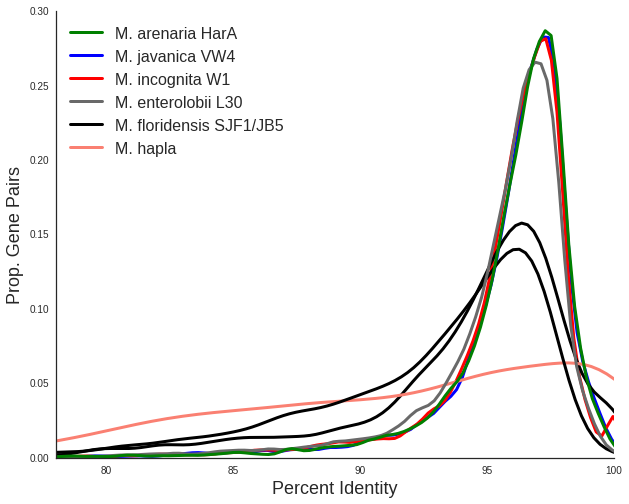

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pickle
import glob
from collections import Counter
from itertools import chain
import numpy as np
import seaborn as sns

# convert data point to sliding avarage
#def smooth(a, half_window = 4):
#    import numpy as np
#    a = list(a)
#    smoothed = []
#    for i in range(len(a)):
#        start = i - half_window
#        end = i + half_window+1
#        if start < 0:
#            start = 0
#        smoothed.append(np.mean(a[start:end]))
#    return smoothed

sns.set_style("white")
# Load the data
#with open('./intrablast_p_ident_dict.pkl','rb') as hndl:
#    p_ident = pickle.load(hndl)

# plot the histograms
fig, ax = plt.subplots(figsize=(10,8))
bins = []

colors = {'Mjav':'blue','Mflo':'black','Mare':'green',
          'Minc':'red', 'Ment': 'DimGray', 'Abad': 'purple'}

for smpl in p_ident:
    if not 'ref' in smpl and not 'Mhap' in smpl:
        continue
    
    color = 'salmon'
    if smpl[:4] in colors:
        color = colors[smpl[:4]]    
    w = 3
    if 'Abad' in smpl:
        w = 6
    
    d = p_ident[smpl]
    
    #if len(bins) > 0:
        
    sns.distplot(d,
                 hist=False,
                 color=color,
                 kde_kws={'shade': False, 'lw':w},
                 #rug=True,
                 )
        
    #    values, bins = np.histogram(d, bins=bins)
        
    #    a = ax.plot(bins[1:],
    #                smooth(values),
    #                color= color,
    #                linewidth=w
    #               )
        
    #else:
        
    #    values, bins = np.histogram(d, bins=200)
          
    #    a = ax.plot(bins[1:],
    #                smooth(values),
    #                color= color,
    #                linewidth=w,
    #               )


# plot the axes        
#for tick in ax.yaxis.get_major_ticks():
#    tick.label.set_fontsize(16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(16)
      
ax.set_xlim(78,100)

plt.xlabel('Percent Identity', fontsize=18)
plt.ylabel('Prop. Gene Pairs', fontsize=18)

# Plot the legend
Mare_line = mlines.Line2D([0,1], [0,0], color='green',
                          linewidth=3, label='M. arenaria HarA')
Mjav_line = mlines.Line2D([0,1], [0,0], color='blue',
                          linewidth=3, label='M. javanica VW4')
Minc_line = mlines.Line2D([0,1], [0,0], color='red',
                          linewidth=3, label='M. incognita W1')
Ment_line = mlines.Line2D([0,1], [0,0], color='dimgray',
                          linewidth=3, label='M. enterolobii L30')
Mflo_line = mlines.Line2D([0,1], [0,0], color='black',
                          linewidth=3, label='M. floridensis SJF1/JB5')
hapchi_line = mlines.Line2D([0,1], [0,0], color='salmon',
                          linewidth=3, label='M. hapla')
#other = mlines.Line2D([0,1], [0,0], color='silver',
#                          linewidth=1, label='other samples')

plt.legend(handles=[Mare_line,Mjav_line,
                    Minc_line,Ment_line,Mflo_line,hapchi_line],
           loc=2, fontsize = 16)

sns.despine()
# Save the figure
plt.savefig('intra_blast_hi.png', dpi=900)

# Count genes with stop codons

In [38]:
from Bio import SeqIO

Prot_files = {'Abad': './GS978784/mi.protein.faa',
             'MareHarA_ref': './all_protein_ref_reviewed/MareHarA_ref.aa.fasta',
             'MareL28': './all_proteins/MareL28.aa.fasta',
             'MareL32': './all_proteins/MareL32.aa.fasta',
             'MentL30_ref': './all_protein_ref_reviewed/MentL30_ref.aa.fasta',
             'MfloJB5_ref': './GS978784/mf.protein.faa',
             'MfloSJF1_ref': './all_protein_ref_reviewed/MfloSJF1_ref.aa.fasta',
             'Minc557R': './all_proteins/Minc557R.aa.fasta',
             'MincA14': './all_proteins/MincA14.aa.fasta',
             'MincHarC': './all_proteins/MincHarC.aa.fasta',
             'MincL15': './all_proteins/MincL15.aa.fasta',
             'MincL17': './all_proteins/MincL17.aa.fasta',
             'MincL19': './all_proteins/MincL19.aa.fasta',
             'MincL27': './all_proteins/MincL27.aa.fasta',
             'MincL9': './all_proteins/MincL9.aa.fasta',
             'MincVW6': './all_proteins/MincVW6.aa.fasta',
             'MincW1_ref': './all_protein_ref_reviewed/MincW1_ref.aa.fasta',
             'MjavL57': './all_proteins/MjavL57.aa.fasta',
             'MjavVW4_ref': './all_protein_ref_reviewed/MjavVW4_ref.aa.fasta',
             'MjavVW5': './all_proteins/MjavVW5.aa.fasta'}


stops = {'Sample':[],'BothStop':[], 'OneStop':[], 'NoneStop':[], 'PropNoneStop': []}

for smpl in results:
    if '_OG' in smpl:
        continue
    records = SeqIO.to_dict(SeqIO.parse(Prot_files[smpl],'fasta'))
    lines = results[smpl].write_blast_results(95.5,97.5).splitlines()[5:-3]
    BothStop = 0
    OneStop = 0
    NoneStop = 0
    for l in lines:
        q, t, ident, lenprop = l.split()
        if float(lenprop) < 0.98:
            continue
        stop1 = str(records[q].seq).count('*') + str(records[q].seq).count('x') + str(records[q].seq).count('X')
        stop2 = str(records[t].seq).count('*') + str(records[q].seq).count('x') + str(records[q].seq).count('X')
        state = None
        if stop1 > 0 and stop2 > 0:
            BothStop += 1
        elif (stop1 > 0 and stop2 == 0) or (stop2 > 0 and stop1 == 0):
            OneStop += 1
        elif stop1 == 0 and stop2 == 0:
            NoneStop += 1
    stops['Sample'].append(smpl)
    stops['BothStop'].append(BothStop)
    stops['OneStop'].append(OneStop)
    stops['NoneStop'].append(NoneStop)
    stops['PropNoneStop'].append(NoneStop/float(BothStop+OneStop+NoneStop))

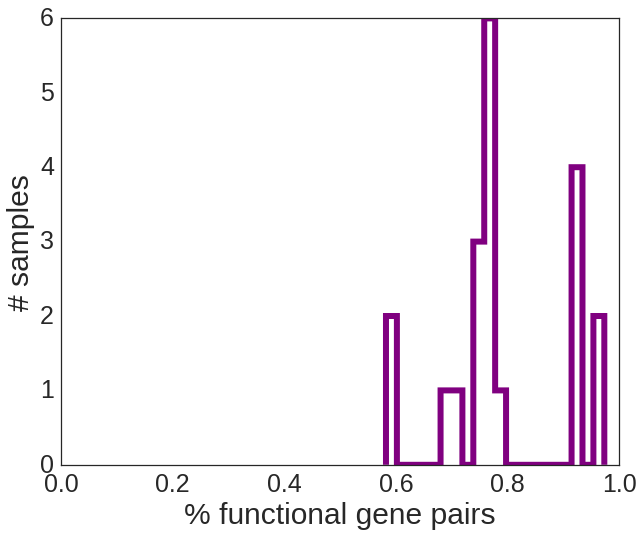

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

fig, ax = plt.subplots(figsize=(10,8))

d = stops['PropNoneStop']

sns.distplot(d,
             #hist=False,
             bins=20,
             kde=False,
             color='purple',
             hist_kws={"histtype": "step", 'alpha': 1,'lw':6}
            )

ax.set_xlim(0,1)

plt.xlabel('% functional gene pairs', fontsize=30)
plt.ylabel('# samples', fontsize=30)

# plot the axes        
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)


#sns.despine()
# Save the figure
plt.savefig('intra_blast_inset.png', dpi=300)